In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Load your data (assuming you have separate DataFrames for each era)
df_luis = pd.read_csv("/content/sample_data/barca_filtered_events_luis.csv")  # Luis Enrique era
df_valverde = pd.read_csv("/content/sample_data/barca_filtered_events_after.csv")  # Valverde era

# Filter for only pass events
luis_passes = df_luis[df_luis['event_type'] == 'Pass'].copy()
valverde_passes = df_valverde[df_valverde['event_type'] == 'Pass'].copy()

In [46]:
# Calculate average pass lengths
avg_pass_length_luis = luis_passes['pass_length'].mean()
avg_pass_length_valverde = valverde_passes['pass_length'].mean()

print(f"Luis Enrique era average pass length: {avg_pass_length_luis:.2f} yards")
print(f"Valverde era average pass length: {avg_pass_length_valverde:.2f} yards")


#Valverde era is higer average more then 1 yard approx in professional football it means more direct play

Luis Enrique era average pass length: 19.51 yards
Valverde era average pass length: 18.54 yards


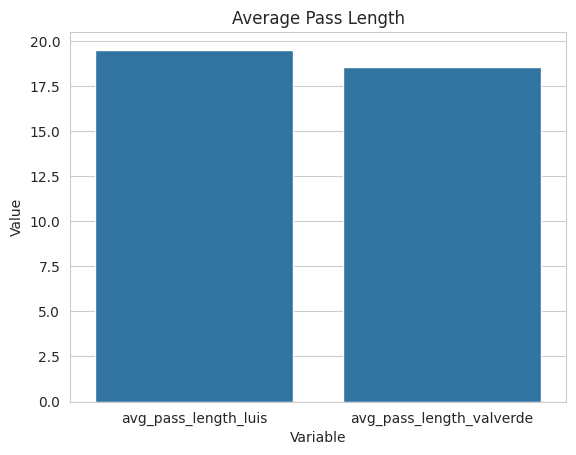

In [47]:
data_pass_length={
    'Variable':['avg_pass_length_luis','avg_pass_length_valverde'],
    'Value':[avg_pass_length_luis,avg_pass_length_valverde]
}
df_bar_graph_length=pd.DataFrame(data_pass_length)
#Plotting bar Graph
sns.barplot(x='Variable',y='Value',data=df_bar_graph_length)
plt.title('Average Pass Length')
plt.show()


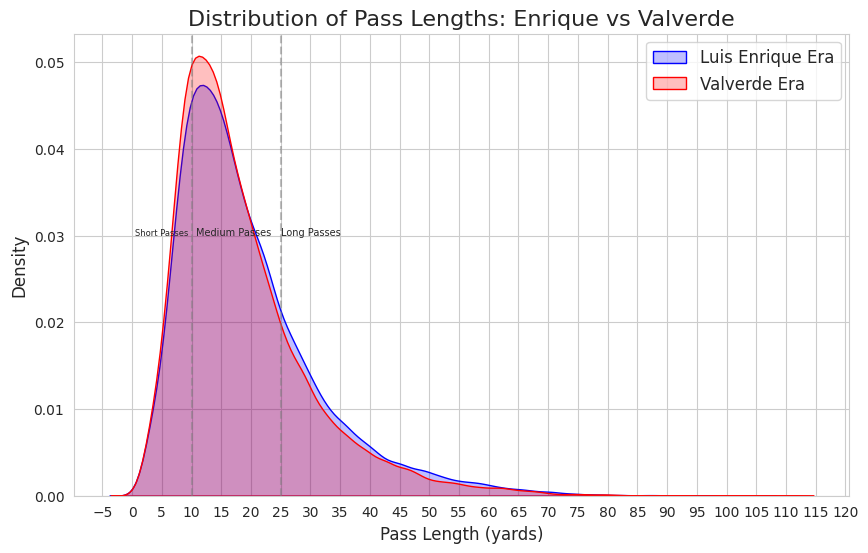

In [48]:
import matplotlib.ticker as ticker

# Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create kernel density plots for both eras
ax=sns.kdeplot(luis_passes['pass_length'], label='Luis Enrique Era', color='blue', fill=True)
sns.kdeplot(valverde_passes['pass_length'], label='Valverde Era', color='red', fill=True)

# Set x-axis ticks every 5 yards from 0 to max pass length
max_length = max(luis_passes['pass_length'].max(), valverde_passes['pass_length'].max())
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))  # Major ticks every 5 yards
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks every 1 yard

# Add titles and labels
x_min,x_max=plt.gca().get_xlim()
plt.title('Distribution of Pass Lengths: Enrique vs Valverde', fontsize=16)
plt.xlabel('Pass Length (yards)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)

# Highlight key zones
plt.axvline(x=10, color='gray', linestyle='--', alpha=0.5) # short passes threshold
plt.axvline(x=25, color='gray', linestyle='--', alpha=0.5) # Long passes threshold
plt.text(5, 0.03, 'Short Passes',fontsize=6, ha='center')
plt.text(17, 0.03, 'Medium Passes',fontsize=7, ha='center')
plt.text(30, 0.03, 'Long Passes',fontsize=7, ha='center')

plt.show()

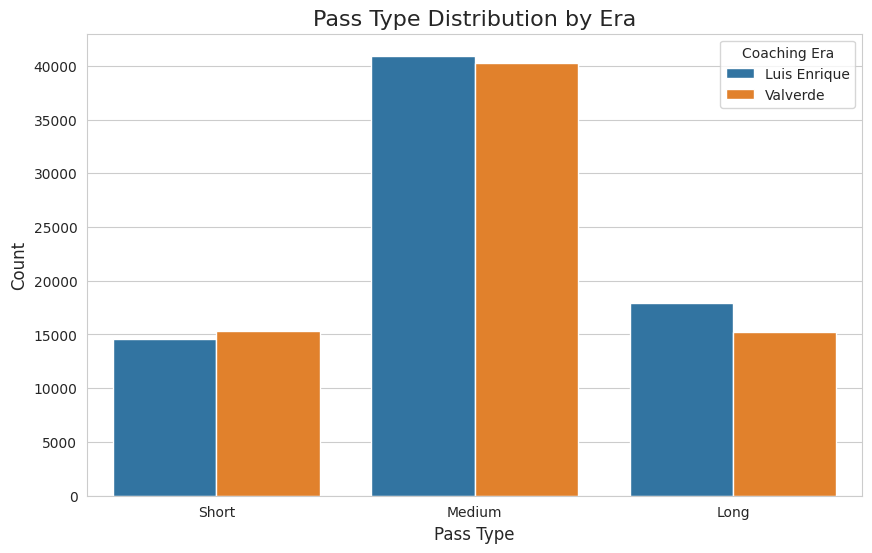

In [49]:
# Define pitch zones using location coordinates
def classify_pass_zone(x_start, y_start, x_end, y_end):
    # Simple zone classification - can be refined
    length = ((x_end-x_start)**2 + (y_end-y_start)**2)**0.5 #distance between two co ordinate

    #whats general defination of pass
    if length < 10:
        return 'Short'
    elif length < 25:
        return 'Medium'
    else:
        return 'Long'

# Apply to both datasets
luis_passes['pass_type'] = luis_passes.apply(
    lambda row: classify_pass_zone(row['location_x'], row['location_y'],
                                 row['pass_end_x'], row['pass_end_y']), axis=1)

valverde_passes['pass_type'] = valverde_passes.apply(
    lambda row: classify_pass_zone(row['location_x'], row['location_y'],
                                  row['pass_end_x'], row['pass_end_y']), axis=1)

# Create comparison plot
plt.figure(figsize=(10, 6))
sns.countplot(data=pd.concat([
    luis_passes.assign(Era='Luis Enrique'),
    valverde_passes.assign(Era='Valverde')
]), x='pass_type', hue='Era', order=['Short', 'Medium', 'Long'])

plt.title('Pass Type Distribution by Era', fontsize=16)
plt.xlabel('Pass Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Coaching Era')
plt.show()

In [50]:
!pip install mplsoccer

In [51]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch

In [52]:
# Calculate pass vectors (dx, dy) for each era
luis_passes['dx'] = luis_passes['pass_end_x'] - luis_passes['location_x']
luis_passes['dy']=luis_passes['pass_end_y']-luis_passes['location_x']

In [53]:
#For Valverde era
valverde_passes['dx'] = valverde_passes['pass_end_x'] - valverde_passes['location_x']
valverde_passes['dy'] = valverde_passes['pass_end_y'] - valverde_passes['location_y']

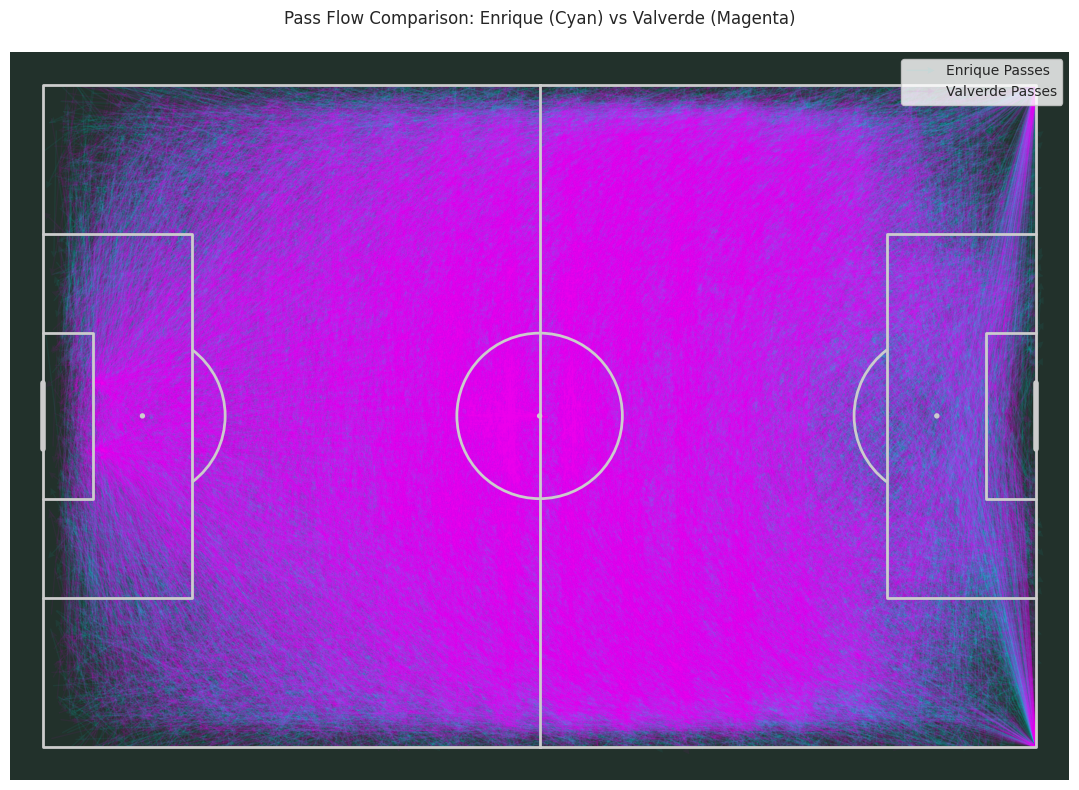

In [54]:
# Set up pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b')
fig, ax = pitch.draw(figsize=(12, 8))

# Luis Enrique's pass flow
pitch.arrows(
    luis_passes['location_x'], luis_passes['location_y'],
    luis_passes['pass_end_x'], luis_passes['pass_end_y'],
    color='cyan', ax=ax, width=1, headwidth=5, alpha=0.05, label='Enrique Passes'
)

# Valverde's pass flow (overlay half-transparent)
pitch.arrows(
    valverde_passes['location_x'], valverde_passes['location_y'],
    valverde_passes['pass_end_x'], valverde_passes['pass_end_y'],
    color='magenta', ax=ax, width=1, headwidth=5, alpha=0.05, label='Valverde Passes'
)

plt.legend()
plt.title('Pass Flow Comparison: Enrique (Cyan) vs Valverde (Magenta)', pad=20)
plt.show()

In [56]:
#this all to make pass networks
# count the passes between each player and recipient
pass_counts_luis = luis_passes.groupby(['player', 'recipient']).size().reset_index(name='pass_count')
'''
pass_counts_luis we group player and recipient and check how many times {player,recipient} appears and count the number of
appearance so we have kinda a Series with a MultiIndex and the counts as values
by reset_index() we have make it again into a dataframe and by name='pass_count' we rename size as pass_count
'''
#pd.set_option('display.max_rows', None) for debug puposes
# See the top passing combinations
print("Top 11 Passing Combinations (Luis Enrique Era):")
print(pass_counts_luis.sort_values(by='pass_count', ascending=False).head(11))

Top 11 Passing Combinations (Luis Enrique Era):
                             player                       recipient  \
384                Jordi Alba Ramos   Neymar da Silva Santos Junior   
179           Daniel Alves da Silva  Lionel Andrés Messi Cuccittini   
644   Neymar da Silva Santos Junior  Lionel Andrés Messi Cuccittini   
806        Sergio Busquets i Burgos  Lionel Andrés Messi Cuccittini   
460  Lionel Andrés Messi Cuccittini   Neymar da Silva Santos Junior   
364                Jordi Alba Ramos            Andrés Iniesta Luján   
304                    Ivan Rakitić  Lionel Andrés Messi Cuccittini   
95             Andrés Iniesta Luján   Neymar da Silva Santos Junior   
85             Andrés Iniesta Luján                Jordi Alba Ramos   
269           Gerard Piqué Bernabéu     Javier Alejandro Mascherano   
506        Luis Alberto Suárez Díaz  Lionel Andrés Messi Cuccittini   

     pass_count  
384        1397  
179        1018  
644         983  
806         956  
460      

In [57]:
avg_locations_luis=luis_passes.groupby('player').agg({
    'location_x':'mean',
    'location_y':'mean'
}).reset_index()
'''
this will give us a dataframe with player name and location_x mean of all location_x in original
for our corresponding player same as for location_y
'''

'\nthis will give us a dataframe with player name and location_x mean of all location_x in original\nfor our corresponding player same as for location_y\n'

In [58]:
'''
Note- pass_counts_luis is dataframe consisting of Player recipent and pass_count
'''
# Merge the average locations with the pass counts
# First, for the passer (player)
pass_counts_luis = pass_counts_luis.merge(avg_locations_luis, on='player')
'''
we merge previous dataframe avg_locations and this pass_counts_luis with key as player
we have to do the samme for recipient have to find out average location of recipient and save
them as recipient_x and recipient_y so the new key will be recipient as of luis_counts_pass
renaming player as recipient location_x as recipent_x and same as y to make this happen
so we can make recipient as key

'''
# Then, for the receiver (recipient)

avg_locations_luis_recipient = avg_locations_luis.rename(columns={'player': 'recipient', 'location_x': 'recipient_x', 'location_y': 'recipient_y'})
pass_counts_luis = pass_counts_luis.merge(avg_locations_luis_recipient, on='recipient')
'''
now pass_counts_luis has player reciepient pass_counts location_x as of player recipient_x as of recipient
'''
print("\nFinal Merged DataFrame for Plotting:")
print(pass_counts_luis.head())


Final Merged DataFrame for Plotting:
                  player                   recipient  pass_count  location_x  \
0  Adriano Correia Claro          Aleix Vidal Parreu           1   68.327368   
1  Adriano Correia Claro        Andrés Iniesta Luján          26   68.327368   
2  Adriano Correia Claro                  Arda Turan          22   68.327368   
3  Adriano Correia Claro  Claudio Andrés Bravo Muñoz          18   68.327368   
4  Adriano Correia Claro       Daniel Alves da Silva           9   68.327368   

   location_y  recipient_x  recipient_y  
0   22.530965    68.253317    71.043554  
1   22.530965    70.957744    26.131687  
2   22.530965    74.772049    35.181858  
3   22.530965    11.729375    40.132188  
4   22.530965    68.915807    68.616882  


In [59]:
# Set a threshold for the minimum number of passes to be shown taking only those that can give a picture
MIN_PASS_COUNT = 100
significant_passes_luis = pass_counts_luis[pass_counts_luis['pass_count'] > MIN_PASS_COUNT]


In [60]:
#for readability
name_map = {
    "Jordi Alba Ramos": "Alba",
    "Neymar da Silva Santos Junior": "Neymar",
    "Daniel Alves da Silva": "Dani Alves",
    "Lionel Andrés Messi Cuccittini": "Messi",
    "Sergio Busquets i Burgos": "Busquets",
    "Andrés Iniesta Luján": "Iniesta",
    "Ivan Rakitić": "Rakitić",
    "Gerard Piqué Bernabéu": "Piqué",
    "Javier Alejandro Mascherano": "Mascherano",
    "Luis Alberto Suárez Díaz": "Suárez",
    "Sergi Roberto Carnicer": "Sergi Roberto",
    "Jérémy Mathieu": "Mathieu",
    "Claudio Andrés Bravo Muñoz": "Bravo"
}
# Apply name map to both passer and recipient columns if needed
avg_locations_luis['short_name'] = avg_locations_luis['player'].map(name_map)
mask = avg_locations_luis['short_name'].isna()
avg_locations_luis.loc[mask, 'short_name'] = avg_locations_luis.loc[mask, 'player'].apply(lambda x: x.split()[0])


In [61]:
!pip install mplsoccer

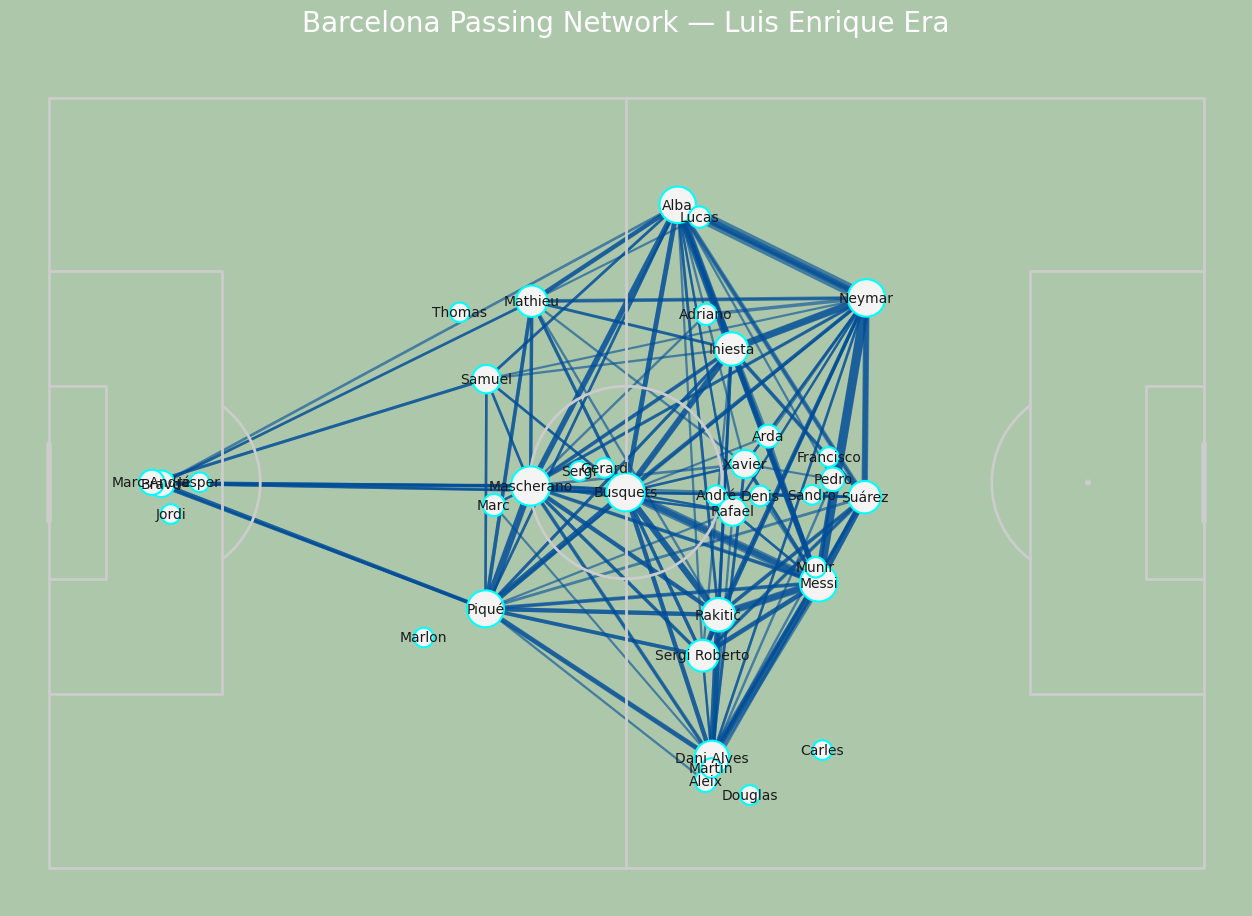

In [79]:
from collections import Counter
from matplotlib.patheffects import withStroke
TITLE_COLOR = '#004D98' # Title color to match node edges/pass lines
PITCH_COLOR = '#ADC7AB' # A slightly more muted, less vibrant green for the pitch
FIG_BG_COLOR = '#ADC7AB' # Match figure background to pitch color

#  Setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color=PITCH_COLOR)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(FIG_BG_COLOR)

#  Scale line widths based on pass_count
max_pass_count = significant_passes_luis['pass_count'].max()

#this is to make edges
for _, row in significant_passes_luis.iterrows():
    respective_thickness=0.1
    if max_pass_count > 0:
      respective_thickness=row.pass_count / max_pass_count
    lw = 1 + respective_thickness * 8  # adaptive thickness
    pitch.lines(
        row.location_x, row.location_y,
        row.recipient_x, row.recipient_y,
        lw=lw,
        color='#004D98',
        alpha=0.6,
        zorder=1,
        ax=ax
    )

#  Node size scaling: total involvement (sent + received passes) Nodes with player
player_counts = Counter(significant_passes_luis['player']) + Counter(significant_passes_luis['recipient'])

# Add involvement counts to avg_locations_luis
avg_locations_luis['total_passes'] = avg_locations_luis['player'].map(player_counts)
avg_locations_luis['total_passes'] = avg_locations_luis['total_passes'].fillna(0)
max_involvement = avg_locations_luis['total_passes'].max()
avg_locations_luis['marker_size'] = 200 + (avg_locations_luis['total_passes'] / max_involvement) * 600

#  Plot nodes
pitch.scatter(
    avg_locations_luis['location_x'], avg_locations_luis['location_y'],
    s=avg_locations_luis['marker_size'],
    color='#f4f4f4',
    edgecolors='cyan',
    linewidth=1.5,
    zorder=2,
    ax=ax
)

#  Annotate player names
for _, row in avg_locations_luis.iterrows():
    #short_name = row['player'].split()[-1]  # Use last name
    pitch.annotate(
        row.short_name,
        xy=(row['location_x'], row['location_y']),
        c='#1a1a1a',
        va='center',
        ha='center',
        size=10,
        ax=ax,
    )

#  Add title
ax.set_title("Barcelona Passing Network — Luis Enrique Era", color='white', fontsize=20, pad=20)

#  Show plot
plt.show()

Top 11 Passing Combinations (Ernesto valverde Era):
                              player                       recipient  \
1001        Sergio Busquets i Burgos  Lionel Andrés Messi Cuccittini   
958           Sergi Roberto Carnicer  Lionel Andrés Messi Cuccittini   
399                     Ivan Rakitić  Lionel Andrés Messi Cuccittini   
351            Gerard Piqué Bernabéu          Sergi Roberto Carnicer   
487                 Jordi Alba Ramos        Luis Alberto Suárez Díaz   
560   Lionel Andrés Messi Cuccittini        Luis Alberto Suárez Díaz   
951           Sergi Roberto Carnicer                    Ivan Rakitić   
415                     Ivan Rakitić        Sergio Busquets i Burgos   
414                     Ivan Rakitić          Sergi Roberto Carnicer   
992         Sergio Busquets i Burgos           Gerard Piqué Bernabéu   
339            Gerard Piqué Bernabéu           Marc-André ter Stegen   

      pass_count  
1001        1077  
958          843  
399          829  
351    

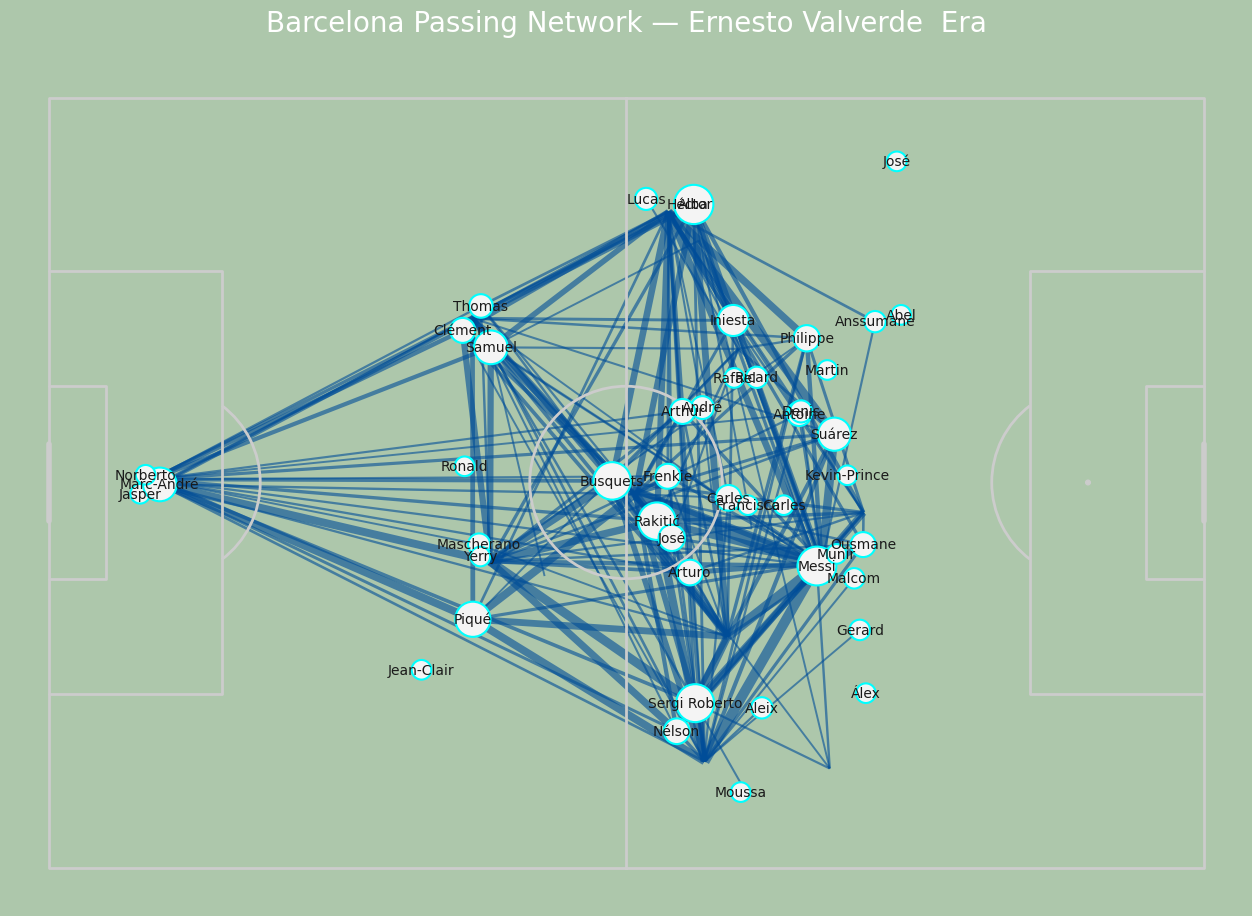

In [78]:
#this all to make pass networks
# count the passes between each player and recipient
pass_counts_valverde = valverde_passes.groupby(['player', 'recipient']).size().reset_index(name='pass_count')
'''
pass_counts_valverde we group player and recipient and check how many times {player,recipient} appears and count the number of
appearance so we have kinda a Series with a MultiIndex and the counts as values
by reset_index() we have make it again into a dataframe and by name='pass_count' we rename size as pass_count
'''
#pd.set_option('display.max_rows', None) for debug puposes
# See the top passing combinations
print("Top 11 Passing Combinations (Ernesto valverde Era):")
print(pass_counts_valverde.sort_values(by='pass_count', ascending=False).head(11))
avg_locations_valverde=valverde_passes.groupby('player').agg({
    'location_x':'mean',
    'location_y':'mean'
}).reset_index()
'''
this will give us a dataframe with player name and location_x mean of all location_x in original
for our corresponding player same as for location_y
'''
'''
Note- pass_counts_valverde is dataframe consisting of Player recipent and pass_count
'''
# Merge the average locations with the pass counts
# First, for the passer (player)
pass_counts_valverde = pass_counts_valverde.merge(avg_locations_valverde, on='player')
'''
we merge previous dataframe avg_locations and this pass_counts_valverde with key as player
we have to do the samme for recipient have to find out average location of recipient and save
them as recipient_x and recipient_y so the new key will be recipient as of valverde_counts_pass
renaming player as recipient location_x as recipent_x and same as y to make this happen
so we can make recipient as key

'''
# Then, for the receiver (recipient)

avg_locations_valverde_recipient = avg_locations_valverde.rename(columns={'player': 'recipient', 'location_x': 'recipient_x', 'location_y': 'recipient_y'})
pass_counts_valverde = pass_counts_valverde.merge(avg_locations_valverde_recipient, on='recipient')
'''
now pass_counts_valverde has player reciepient pass_counts location_x as of player recipient_x as of recipient
'''
print("\nFinal Merged DataFrame for Plotting:")
print(pass_counts_valverde.head())
# Apply name map to both passer and recipient columns if needed
avg_locations_valverde['short_name'] = avg_locations_valverde['player'].map(name_map)
mask = avg_locations_valverde['short_name'].isna()
avg_locations_valverde.loc[mask, 'short_name'] = avg_locations_valverde.loc[mask, 'player'].apply(lambda x: x.split()[0])
from collections import Counter
from matplotlib.patheffects import withStroke

TITLE_COLOR = '#004D98' # Title color to match node edges/pass lines
PITCH_COLOR = '#ADC7AB' # A slightly more muted, less vibrant green for the pitch
FIG_BG_COLOR = '#ADC7AB' # Match figure background to pitch color

#  Setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color=PITCH_COLOR)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(FIG_BG_COLOR)

#  Scale line widths based on pass_count
max_pass_count = significant_passes_valverde['pass_count'].max()

#this is to make edges
for _, row in significant_passes_valverde.iterrows():
    respective_thickness=0.1
    if max_pass_count > 0:
      respective_thickness=row.pass_count / max_pass_count
    lw = 1 + respective_thickness * 8  # adaptive thickness
    pitch.lines(
        row.location_x, row.location_y,
        row.recipient_x, row.recipient_y,
        lw=lw,
        color='#004D98',
        alpha=0.6,
        zorder=1,
        ax=ax
    )

#  Node size scaling: total involvement (sent + received passes) Nodes with player
player_counts = Counter(significant_passes_valverde['player']) + Counter(significant_passes_valverde['recipient'])

# Add involvement counts to avg_locations_valverde
avg_locations_valverde['total_passes'] = avg_locations_valverde['player'].map(player_counts)
avg_locations_valverde['total_passes'] = avg_locations_valverde['total_passes'].fillna(0)
max_involvement = avg_locations_valverde['total_passes'].max()
avg_locations_valverde['marker_size'] = 200 + (avg_locations_valverde['total_passes'] / max_involvement) * 600

#  Plot nodes
pitch.scatter(
    avg_locations_valverde['location_x'], avg_locations_valverde['location_y'],
    s=avg_locations_valverde['marker_size'],
    color='#f4f4f4',
    edgecolors='cyan',
    linewidth=1.5,
    zorder=2,
    ax=ax
)

#  Annotate player names
for _, row in avg_locations_valverde.iterrows():
    #short_name = row['player'].split()[-1]  # Use last name
    pitch.annotate(
        row.short_name,
        xy=(row['location_x'], row['location_y']),
        c='#1a1a1a',
        va='center',
        ha='center',
        size=10,
        ax=ax,
    )

#  Add title
ax.set_title("Barcelona Passing Network — Ernesto Valverde  Era", color='white', fontsize=20, pad=20)

#  Show plot
plt.show()